#1. Importar librerías

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml

#2. Cargar y visualizar el conjunto de datos

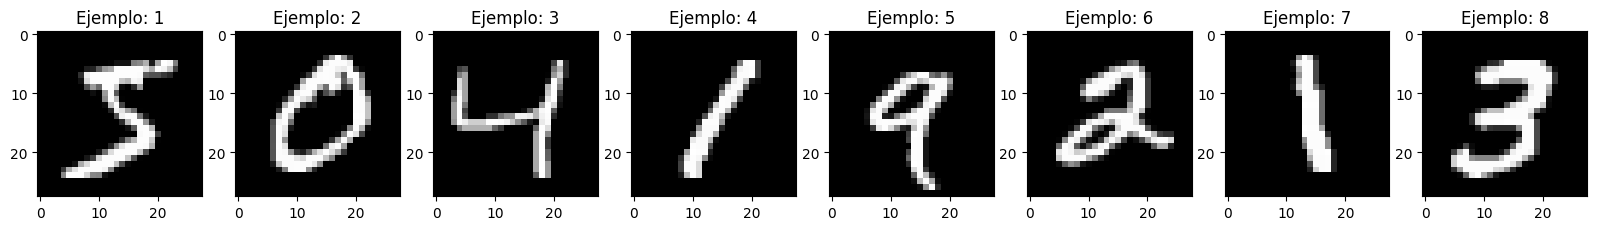

In [3]:
# Cargar el conjunto de datos MNIST de la plataforma OpenML
mnist = fetch_openml('mnist_784', as_frame=False, parser='auto')

# Establecer el lienzo en el que se dibujarán las imágenes.
plt.figure(figsize=(20, 4))

# Visualización de las primeras 8 imágenes del conjunto de datos MNIST
for index, digit in zip(range(1, 9), mnist.data[:8]):
    plt.subplot(1, 8, index)
    plt.imshow(np.reshape(digit, (28,28)), cmap=plt.cm.gray)
    plt.title('Ejemplo: ' + str(index))
plt.show()

Como se puede observar, estamos ante un conjunto de imagenes que están representadas en escala de grises, lo que implica que cada píxel tiene un valor de intensidad que varía entre 0 y 255. Cada imagen en el conjunto MNIST es una cuadrícula de 28 x 28 píxeles.

#3. Preparación de datos

In [4]:
# Convertir las etiquetas a tipo entero
X = mnist.data
y = mnist.target.astype(int)

# Normalizar los datos
X = X / 255

# Convertir las etiquetas enteras en un formato de vectores binarios (one-hot encoding). En este caso, num_classes=10 porque hay 10 posibles clases (dígitos del 0 al 9).
# Por ejemplo, si una etiqueta es 3, se convierte en el vector [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y = to_categorical(y, num_classes=10)

La normalización ayuda a mejorar la convergencia del modelo y a estabilizar el entrenamiento. Los valores de píxeles están en un rango fijo (0 a 255), por lo que al dividir por 255, se escala a un rango más pequeño y manejable (0 a 1). Esto es especialmente útil para redes neuronales, que tienden a funcionar mejor cuando las entradas están normalizadas.

Por otro lado, la conversión de las etiquetas es importante, ya que las redes neuronales requieren un formato de salida de probabilidad para cada clase. En el caso de la clasificación múltiple, el modelo genera una probabilidad para cada clase, y el one-hot encoding permite que estas probabilidades se comparen directamente con las etiquetas.

#4. Dividir los datos en conjunto de entrenamiento y conjunto de prueba

In [5]:
# Dividir el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

#5. Reformatear los Datos para la CNN

In [6]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

En el conjunto de datos MNIST, cada imagen es una matriz plana (array) de tamaño 784 (28 x 28). Inicialmente, X_train y X_test tienen una forma de (num_samples, 784), donde num_samples es el número de muestras (imagenes) en el conjunto de entrenamiento o prueba.

El reshape de los datos cambia la forma de los datos de entrada de (num_samples, 784) a (numsamples,28,28,1), ya que la forma original aplana las imágenes y pierde la estructura bidimensional de los píxeles, que es crucial para la operación de convolución.

**-1**: El menos 1 indica a la función que calcule automáticamente el tamaño de esa dimensión, y representa el número de muestras (imagenes).
**28, 28**: Las dimensiones espaciales de las imágenes (28 píxeles de alto y 28 píxeles de ancho).

**1**: El número de canales de color. En este caso, es 1 porque las imágenes MNIST son en escala de grises (un solo canal). Para imágenes RGB, este valor sería 3.


#6. Definir el Modelo de la Red Neuronal Convolucional

In [7]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

**Utilizamos el modelo secuencial**, un tipo de modelo de Keras donde las capas se apilan secuencialmente, de modo que cada capa tiene una única entrada y una única salida.

**CAPAS**:

**Primera capa convolucional (Conv2D)**: Esta capa aplica filtros de convolución sobre las imágenes de entrada para extraer características básicas. Utiliza 32 filtros de tamaño 3x3 y la función de activación ReLU, la cual introduce no linealidad en el modelo, permitiéndole aprender representaciones más complejas.

**Primera Capa de Agrupamiento (MacPooling2D)**: Esta capa aplica una operación de agrupamiento máximo con una ventana de 2x2. El agrupamiento máximo reduce la dimensión espacial de la imagen (de 28x28 a 14x14) mientras conserva las características más importantes. Esto ayuda a reducir la complejidad computacional y a evitar el sobreajuste al disminuir el tamaño de la representación intermedia.

**Segunda capa convolucional (Conv2D)**: Esta capa realiza una segunda convolución con 64 filtros de tamaño 3x3. Aumentar el número de filtros permite al modelo extraer características más complejas y abstractas de las imágenes.

**Segunda Capa de Agrupamiento (MacPooling2D)**: Realiza un agrupamiento máximo adicional para seguir reduciendo las dimensiones espaciales y mantener las características más relevantes.

**Capa flatten**: Aplana las salidas del bloque de convolución y agrupamiento en un vector unidimensional antes de pasar a las capas densas, ya que estas esperan vectores unidimensionales.

**Primera Capa Densa (Dense)**: Esta capa completamente conectada con 128 neuronas. Permite que el modelo aprenda combinaciones no lineales de las características extraídas por las capas convolucionales.

**Segunda Capa Densa (Dense)**: Capa de salida con 10 neuronas, una por cada clase, que produce las probabilidades de las 10 clases (dígitos del 0 al 9). La función de activación softmax convierte las salidas en probabilidades que suman 1.

**COMPILACIÓN**:

**Optimizador adam**: Ajusta los pesos del modelo durante el entrenamiento para minimizar la función de pérdida.

**Función de pérdida 'categorical_crossentropy'**: Utiliza la entropía cruzada categórica. Es adecuada para problemas de clasificación multiclase, donde las etiquetas están en formato one-hot encoding.

**Métrica 'accuracy'**: Mide el porcentaje de predicciones correctas entre las predicciones realizadas y las etiquetas verdaderas.



#7. Entrenar el modelo

In [9]:
model.fit(X_train, y_train, epochs=8, batch_size=128, validation_split=0.1)

Epoch 1/8
443/443 [==============================] - 47s 107ms/step - loss: 0.0077 - accuracy: 0.9976 - val_loss: 0.0360 - val_accuracy: 0.9908
Epoch 2/8
443/443 [==============================] - 54s 122ms/step - loss: 0.0059 - accuracy: 0.9982 - val_loss: 0.0367 - val_accuracy: 0.9914
Epoch 3/8
443/443 [==============================] - 53s 120ms/step - loss: 0.0062 - accuracy: 0.9980 - val_loss: 0.0329 - val_accuracy: 0.9927
Epoch 4/8
443/443 [==============================] - 61s 137ms/step - loss: 0.0053 - accuracy: 0.9982 - val_loss: 0.0337 - val_accuracy: 0.9914
Epoch 5/8
443/443 [==============================] - 47s 106ms/step - loss: 0.0036 - accuracy: 0.9988 - val_loss: 0.0410 - val_accuracy: 0.9921
Epoch 6/8
443/443 [==============================] - 55s 124ms/step - loss: 0.0046 - accuracy: 0.9983 - val_loss: 0.0407 - val_accuracy: 0.9911
Epoch 7/8
443/443 [==============================] - 47s 105ms/step - loss: 0.0059 - accuracy: 0.9980 - val_loss: 0.0333 - val_accuracy:

Se observa que a partir del octavo Epoch (iteración completa a través del conjunto de datos de entrenamiento), la precisión ya no aumenta, por lo que vamos a configurar el entrenamiento para que solo realice 8 Epochs. Muchas iteraciones pueden llevar a problemas de sobreajuste.

#8. Evaluar el Modelo

In [10]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

219/219 [==============================] - 2s 10ms/step - loss: 0.0464 - accuracy: 0.9900
Loss: 0.046425092965364456, Accuracy: 0.9900000095367432


La pérdida mide la diferencia entre las predicciones del modelo y las etiquetas verdaderas. Un valor bajo como 0.046 sugiere que el modelo está haciendo predicciones muy cercanas a las verdaderas etiquetas.

La precisión indica que el modelo clasifica correctamente el 99.00% de las imágenes en el conjunto de prueba. Es una medida de la proporción de predicciones correctas en relación con el total de predicciones realizadas.

#9. Predicciones y Evaluación

In [11]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calcular el F1-score
f1 = f1_score(y_true, y_pred_classes, average="weighted")
print(f'F1-score: {f1}')

# Mostrar un informe de clasificación detallado
print(classification_report(y_true, y_pred_classes))

219/219 [==============================] - 3s 13ms/step
F1-score: 0.990003732314915
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       683
           1       1.00      1.00      1.00       800
           2       0.99      0.99      0.99       674
           3       0.99      0.99      0.99       760
           4       0.99      0.99      0.99       611
           5       0.98      0.99      0.99       658
           6       1.00      0.99      0.99       677
           7       0.99      0.99      0.99       724
           8       0.98      0.99      0.99       693
           9       0.98      0.99      0.99       720

    accuracy                           0.99      7000
   macro avg       0.99      0.99      0.99      7000
weighted avg       0.99      0.99      0.99      7000




El modelo de clasificación tiene un F1-score general de 0.9900, indicando un equilibrio excelente entre precisión y recall. En el informe de clasificación, todas las clases (dígitos del 0 al 9) muestran altos valores de precisión, recall y F1-score, la mayoría cercanos a 1.00. La precisión global es del 99%, y el rendimiento es consistente en todas las clases, con una leve variación en las clases menos representadas. Esto sugiere que el modelo clasifica con gran precisión y confiabilidad todos los dígitos en el conjunto de datos MNIST.

#10. Visualizar Errores

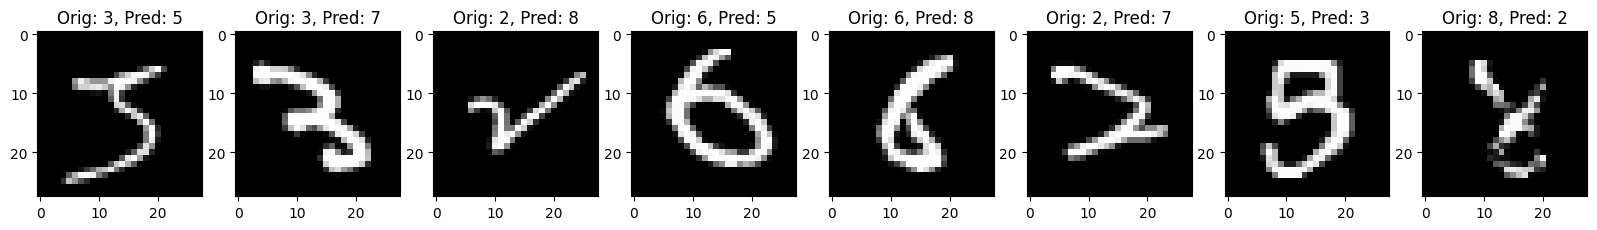

In [12]:
# Encontrar índices de errores
index_errors = [index for index, (true, pred) in enumerate(zip(y_true, y_pred_classes)) if true != pred]

plt.figure(figsize=(20, 4))

for i, img_index in zip(range(1, 9), index_errors[:8]):
    plt.subplot(1, 8, i)
    plt.imshow(X_test[img_index].reshape(28, 28), cmap=plt.cm.gray)
    plt.title(f'Orig: {y_true[img_index]}, Pred: {y_pred_classes[img_index]}')
plt.show()

Al visulizar algunas de las imagenes que nuestro modelo no ha clasificado con éxito, podemos percatarnos de que son en su mayoría imágenes que no tienen clara interpretación. Por ejemplo, en la primera imagen podemos observar que el modelo predice un 5 cuando en realidad es un 3, pero la predicción no está lejos de la realidad, ya que estamos ante un 3 con una forma muy similar a un 5.

#Exportar notebook en formato HTML

In [ ]:
from google.colab import files
import nbformat
from nbconvert import HTMLExporter

# Cargar el archivo del notebook
notebook_filename = '/content/Serie_temporal_demanda_electrica.ipynb'
with open(notebook_filename) as f:
    notebook_content = nbformat.read(f, as_version=4)

# Exportar a HTML
html_exporter = HTMLExporter()
(body, resources) = html_exporter.from_notebook_node(notebook_content)

# Guardar el archivo HTML
with open('notebook_exportado.html', 'w') as f:
    f.write(body)

# Descargar el archivo HTML
files.download('notebook_exportado.html')